# "Ниединогоразыва.com": исследование оттока клиентов

## Описание проекта
Оператор связи предоставляет услуги телефонии (одна или несколько линий) и Интернета (через DSL или оптоволокно), плюс некоторые дополнительные услуги.  

Доступны персональные данные о некоторых клиентах, информация об их тарифах и договорах.  
Информация актуальна на 2020-02-01.  

**Цель проекта**: Построить модель для прогнозирования оттока клиентов, чтобы позволить бизнесу эффективно удерживать клиентов.  

### Первичный анализ

In [66]:
%pip install phik
%pip install scikit-learn==1.1.3
%pip install pandas==1.5.1

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.



In [67]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import catboost

from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

SEED = 190623

Загрузим и проведем предварительное ознакомление с данными:

In [68]:
if os.path.exists('/datasets'):
    try:
        df_contract = pd.read_csv('/datasets/contract_new.csv')
        df_personal = pd.read_csv('/datasets/personal_new.csv')
        df_internet = pd.read_csv('/datasets/internet_new.csv')
        df_phone = pd.read_csv('/datasets/phone_new.csv')
        print('load success: local')
    except Exception as e: print(e)
else:
    try:
        df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
        df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
        df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
        df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
        print('load success: cdn')
    except Exception as e: print(e)

load success: cdn


Проверим общую информацию по наборам данных и выведем несколько строк из каждого набора:

In [69]:
for df in [df_contract, df_personal, df_internet, df_phone]:
    display(df.info());
    display(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


Все наборы данных имеют общий столбец: идентификатор клиента.  
Но не по всем клиентам есть информация в двух наборах (Интернет и телефония).  

Проверим, что клиенты в двух "полных" наборах (персональные данные и договоры) совпадают один к одному.  
То есть - убедимся, что в этих наборах не просто одинаковое количество строк, но идентификаторы клиентов одинаковы: 

In [70]:
(df_contract['customerID'].unique() == df_personal['customerID'].unique()).mean()

1.0

Идентификаторы совпадают.  

Теперь проверим, что идентификаторы из "неполных" наборов целиком содержатся в "полных".  
То есть - что в данных об услугах Интернета и телефонии указаны те же клиенты, которые есть в "наборе" с персональными данными, а не какие-то другие.

In [71]:
print(df_internet['customerID'].isin(df_personal['customerID']).all())
print(df_phone['customerID'].isin(df_personal['customerID']).all())

True
True


"Лишних" клиентов нет.

Итого, осталось убедиться, что суммарное количество уникальных клиентов в наборах подключенных услуг совпадает с количеством клиентов в наборах с персональными данными и договорами:

In [72]:
df_internet.merge(df_phone, on='customerID', how='outer').shape[0]

7043

Можно сделать вывод, что "лишних" клиентов нет, а суммарно все наборы данных содержат информацию об одних и тех же клиентах.

### Предварительные выводы
 - Два файла с описанием услуг не содержат полной информации обо всех клиентах. Но совокупно в них содержится информация об услугах _всех_ клиентов. Можно сделать вывод, что мы имеем полный набор данных по клиентам. А отсутствие информации по услугам в одной из таблиц показывает, что у этого клиента вообще не подключена эта услуга (Интернет или телефония).
 - Все наборы данных содержат идентификатор клиента, по которому можно будет выполнить объединение этих наборов.
 - Типы данных не совпадают с содержимым: большинство столбцов по сути бинарные категории, а столбец TotalCharges - вещественного типа.
 - Столбец EndDate по логике является целевым

###  План работы
 1. Предобработка
  - Объединить выборки по идентификатору клиента
  - Изменить типы данных на соответствующие содержимому
  - Проверить объединенную выборку на пропуски, заполнить или удалить их
  - Добавить столбец с категорией подключенной услуги (Интернет, телефония, обе), либо два столбца (has_internet, has_telephony)
  - Схлопнуть столбцы с доп. услугами в один столбец с _количеством_ подключенных услуг
  - Сформировать столбец с целевым признаком, в котором будет только две категории
 2. Анализ
  - Построить графики распределений признаков в разрезе целевого признака
  - Проверить корреляцию признаков между собой и с целевым признаком
  - Проверить на дисбаланс классов в целевом признаке
 3. Построение моделей
  - Разбить на выборки
  - Для базовых моделей подготовить пайплайн из OHE-кодирования категориальных признаков и StandardScaler для числовых признаков
  - Для моделей бустинга не выполнять кодирование
  - Оценить модели на кросс-валидации и выбрать лучшую
 4. Тестирование лучшей модели
  - Посчитать метрики лучшей модели на тестовой выборке
  - Проверить модель на адекватность
  - Проверить важность признаков модели
  - Построить матрицу ошибок
 5. Отчет \ Итоговые выводы

## Предобработка

### Объединение таблиц
Ранее мы убедились, что во всех датасетах один и тот же набор идентификаторов пользователей, но не во всех датасетах он полный.  
Объединим данные по идентификатору, взяв за основу таблицу с договорами:

In [73]:
df = df_contract.merge(df_personal, on='customerID', how='left')\
                       .merge(df_internet, on='customerID', how='left')\
                       .merge(df_phone, on='customerID', how='left')

Для удобства приведем названия столбцов к единому формату:

In [74]:
import re

def camel_to_snake(string): 
    snakecase = string[0].lower() # первую букву всегда просто в нижний регистр
    for i in string[1:]: # по остальным проходим с заменой больших букв
        if i.isupper():
            snakecase += "_" + i.lower()
        else:
            snakecase += i
    snakecase = re.sub(r"_(.)_", r"_\1", snakecase) # костыль-фикс после замены двух подряд больших букв на два подчеркивания
    return snakecase

for col in df.columns:
    df.rename(columns={col:camel_to_snake(col)}, inplace=True)
    
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


### Пропуски, типы данных, новые фичи
После объединения, если в таблицах с подключенными услугами не было найдено `customer_id`, то должны были появиться пропуски.  
Посмотрим долю этих пропусков в датасете:

In [75]:
df.isna().mean().sort_values(ascending=False)

streaming_movies     0.216669
streaming_tv         0.216669
tech_support         0.216669
device_protection    0.216669
online_backup        0.216669
online_security      0.216669
internet_service     0.216669
multiple_lines       0.096834
begin_date           0.000000
dependents           0.000000
customer_id          0.000000
senior_citizen       0.000000
gender               0.000000
total_charges        0.000000
monthly_charges      0.000000
payment_method       0.000000
paperless_billing    0.000000
type                 0.000000
end_date             0.000000
partner              0.000000
dtype: float64

Пропусков достаточно много, 10 и 20%.  
Но как выяснили ранее, на самом деле **пропуск означает, что у клиента вообще не подключена услуга Интернет\телефонии**.  

То есть, если нет идентификатора клиента в одной из таблиц, то у него вообще не подключен Интернет или телефон.  
Если бы Интернет или телефон были подключены без дополнительных услуг, то соответствующие столбцы просто были бы заполнены как _"No"_.

Для удобства сведем информацию об этом в новые столбцы: `has_internet`, `has_telephony`.  

In [76]:
df['has_internet'] = df['customer_id'].isin(df_internet['customerID'])
df['has_telephony'] = df['customer_id'].isin(df_phone['customerID'])

В датасете есть много столбцов, которые содержат значения _Yes\No_ и являются по сути булевыми, но хранятся как строки.  
Проверим, сколько категорий в столбцах:

In [77]:
df.nunique()

customer_id          7043
begin_date             77
end_date               67
type                    3
paperless_billing       2
payment_method          4
monthly_charges      1585
total_charges        6658
gender                  2
senior_citizen          2
partner                 2
dependents              2
internet_service        2
online_security         2
online_backup           2
device_protection       2
tech_support            2
streaming_tv            2
streaming_movies        2
multiple_lines          2
has_internet            2
has_telephony           2
dtype: int64

В таблице нет дубликатов: **количество уникальных идентификаторов клиентов совпадает с общим количеством строк** датафрейма.  
Неявные дубликаты искать не имеет смысла: совпадение имеющихся данных по разным клиентам теоретически возможно, поэтому мы не сможем определить, дубликат ли это или нет.

Большинство столбцов действительно содержат по две категории и их можно преобразовать в булевы.  
Но сначала проверим столбцы, в которых есть 3-4 категории: возможно, их тоже можно привести к двум категориям:

In [78]:
display(pd.DataFrame(df['type'].value_counts(dropna=False)))
display(pd.DataFrame(df['payment_method'].value_counts(dropna=False)))
display(pd.DataFrame(df['internet_service'].value_counts(dropna=False)))

,type
Month-to-month,3875
Two year,1695
One year,1473


,payment_method
Electronic check,2365
Mailed check,1612
Bank transfer (automatic),1544
Credit card (automatic),1522


,internet_service
Fiber optic,3096
DSL,2421
NaN,1526


Нет, ошибок в данных нет и в этих столбцах действительно более двух категорий.  
В столбце `internet_service` есть пропуски, но они являются следствием объединения таблиц. И означают, что по текущему клиенту не было записей в таблице с услугами интернета. А это значит, что у пользователя вообще не подключен Интернет.  
Поэтому можно заполнить пропуски в этом столбце отдельной соответствующей категорией:

In [79]:
df['internet_service'] = df['internet_service'].fillna('No internet')

Вернемся к текстовым столбцам, которые на самом деле являются бинарными категориальными.  
Те столбцы, в которых нет пропусков, просто преобразуем в булевы.
Перед этим заменим текстовые значения _Yes\No_ на числовые.

In [80]:
# заменяем все текстовые Yes\No на числовые 1\0
df[['paperless_billing', 'partner', 'dependents', # персональные
    'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', # интернет
    'multiple_lines']] =\
df[['paperless_billing', 'partner', 'dependents', 
    'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 
    'multiple_lines']].replace({'No': 0, 'Yes': 1})

# меняем тип в столбцах без пропусков
df[['paperless_billing', 'senior_citizen', 'partner', 'dependents']] =\
    df[['paperless_billing', 'senior_citizen', 'partner', 'dependents']].astype(bool)

Оставшиеся столбцы с пропусками представляют информацию о каждой подключенной _дополнительной_ услуге.  
Попробуем схлопнуть такие признаки в один столбец `additional_services`, который будет содержать общее количество подключенных услуг, суммарно и для Интернет и для телефонии. Затем можно будет удалить исходные столбцы.

In [81]:
df['additional_services'] = \
df[['online_backup','online_security','device_protection','tech_support','streaming_tv','streaming_movies','multiple_lines']]\
.sum(axis = 1).astype(int)

df['additional_services'].value_counts(dropna=False)

0    1667
1    1158
3     978
2     957
4     933
5     722
6     420
7     208
Name: additional_services, dtype: int64

Столбец `total_charges` нужно преобразовать в численный тип.  
Проверим, почему сейчас он типа _object_ - возможно, в нём есть записи, не являющиеся числами:

In [82]:
t = pd.to_numeric(df['total_charges'], errors='coerce') # попытаемся сконвертировать с заменой не-чисел на NaN
non_nums = pd.isna(t)
print(pd.unique(df['total_charges'][non_nums == True])) # выберем все уникальные не-числа

[' ']


Да, есть записи с пробелом вместо числа. Посмотрим, в каких записях встречаются такие значения:

In [83]:
df[df['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,has_internet,has_telephony,additional_services
488,4472-LVYGI,2020-02-01,No,Two year,True,Bank transfer (automatic),52.55,,Female,False,...,1.0,0.0,1.0,1.0,1.0,0.0,NaN,True,False,4
753,3115-CZMZD,2020-02-01,No,Two year,False,Mailed check,20.25,,Male,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,True,0
936,5709-LVOEQ,2020-02-01,No,Two year,False,Mailed check,80.85,,Female,False,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,True,True,5
1082,4367-NUYAO,2020-02-01,No,Two year,False,Mailed check,25.75,,Male,False,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,False,True,1
1340,1371-DWPAZ,2020-02-01,No,Two year,False,Credit card (automatic),56.05,,Female,False,...,1.0,1.0,1.0,1.0,1.0,0.0,NaN,True,False,5
3331,7644-OMVMY,2020-02-01,No,Two year,False,Mailed check,19.85,,Male,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,True,0
3826,3213-VVOLG,2020-02-01,No,Two year,False,Mailed check,25.35,,Male,False,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,False,True,1
4380,2520-SGTTA,2020-02-01,No,Two year,False,Mailed check,20.00,,Female,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,True,0
5218,2923-ARZLG,2020-02-01,No,One year,True,Mailed check,19.70,,Male,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,True,0
6670,4075-WKNIU,2020-02-01,No,Two year,False,Mailed check,73.35,,Female,False,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,True,True,5


Судя по `begin_date`, это клиенты, которые заключили договор в день выгрузки данных, и скорее всего еще не успели заплатить за услуги, либо это не успело попасть в выгрузку.  
Таких строк всего 11, поэтому просто удалим их из датасета. После этого можно будет преобразовать тип данных столбца.

In [84]:
df = df[df['total_charges'] != ' ']
df['total_charges'] = df['total_charges'].astype(float)

### Целевой признак

Нужно подготовить столбец, содержащий целевой признак: ушел клиент или нет.  
Его можно вычислить на основании того, заполнена ли дата в столбце `end_date` или нет.  

Создадим столбец `churn`, в который подставим `0` в случае, если в `end_date` указано `No`, и `1` во всех остальных случаях:

In [85]:
df['churn'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)
df['churn'] = df['churn'].astype(int)

Столбцы с датами сейчас по сути являются категориальными признаками и сами по себе не принесут пользы для анализа.  
Но можно сгенерировать признак, в котором будет храниться _продолжительность договора_ клиента.  
Для _действующих_ клиентов там будет храниться _продолжительность договора на момент выгрузки_ (2020-02-01).  

Для вычисления продолжительности в днях сначала преобразуем столбцы в тип данных _datetime_. Для этого в `end_date` сначала заменим все _No_ на дату выгрузки:

In [86]:
df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01'

df['begin_date'] = pd.to_datetime(df['begin_date'], yearfirst=True)
df['end_date'] = pd.to_datetime(df['end_date'], yearfirst=True)

df['duration'] = (df['end_date'] - df['begin_date']).dt.days

Наконец, оставим в датафрейме только нужные нам признаки, которые не дублируют друг друга. И выведем итоговую информацию о датасете:

In [87]:
df = df[['customer_id','gender','senior_citizen','partner','dependents', # personal
         'type','paperless_billing','payment_method','monthly_charges','total_charges', # contract
         'internet_service', # internet 
         'duration','has_internet','has_telephony','additional_services','churn' # new features
        ]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          7032 non-null   object 
 1   gender               7032 non-null   object 
 2   senior_citizen       7032 non-null   bool   
 3   partner              7032 non-null   bool   
 4   dependents           7032 non-null   bool   
 5   type                 7032 non-null   object 
 6   paperless_billing    7032 non-null   bool   
 7   payment_method       7032 non-null   object 
 8   monthly_charges      7032 non-null   float64
 9   total_charges        7032 non-null   float64
 10  internet_service     7032 non-null   object 
 11  duration             7032 non-null   int64  
 12  has_internet         7032 non-null   bool   
 13  has_telephony        7032 non-null   bool   
 14  additional_services  7032 non-null   int32  
 15  churn                7032 non-null   i

In [88]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,duration,has_internet,has_telephony,additional_services,churn
0,7590-VHVEG,Female,False,True,False,Month-to-month,True,Electronic check,29.85,31.04,DSL,31,True,False,1,0
1,5575-GNVDE,Male,False,False,False,One year,False,Mailed check,56.95,2071.84,DSL,1036,True,True,2,0
2,3668-QPYBK,Male,False,False,False,Month-to-month,True,Mailed check,53.85,226.17,DSL,123,True,True,2,0
3,7795-CFOCW,Male,False,False,False,One year,False,Bank transfer (automatic),42.30,1960.60,DSL,1371,True,False,3,0
4,9237-HQITU,Female,False,False,False,Month-to-month,True,Electronic check,70.70,353.50,Fiber optic,153,True,True,0,0


## Исследовательский анализ

Сначала взглянем на числовое описание данных:

In [89]:
df.describe(include='all')

,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,duration,has_internet,has_telephony,additional_services,churn
count,7032,7032,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000,7032,7032.000000,7032,7032,7032.000000,7032.000000
unique,7032,2,2,2,2,3,2,4,NaN,NaN,3,NaN,2,2,NaN,NaN
top,7590-VHVEG,Male,False,False,False,Month-to-month,True,Electronic check,NaN,NaN,Fiber optic,NaN,True,True,NaN,NaN
freq,1,3549,5890,3639,4933,3875,4168,2365,NaN,NaN,3096,NaN,5512,6352,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.798208,2118.621822,NaN,899.961320,NaN,NaN,2.460040,0.156570
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.085974,2112.736199,NaN,682.738777,NaN,NaN,2.045311,0.363421
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,19.050000,NaN,28.000000,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.587500,439.745000,NaN,276.000000,NaN,NaN,1.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1345.275000,NaN,761.000000,NaN,NaN,2.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.862500,3239.317500,NaN,1461.000000,NaN,NaN,4.000000,0.000000


Можно заметить, что большая часть клиентов - холостые мужчины, а средняя продолжительность договора с провайдером более 2 лет. 
Клиенты подключают и Интернет, и телефонию.  

### Взаимосвязь признаков
Проанализируем, какие есть зависимости между имеющимися признаками и как они влияют на целевой признак - факт разрыва договора.  
Посмотрим на общую phik-корреляцию признаков, а затем на распределение некоторых из них. 

In [90]:
interval_cols = df.select_dtypes(include=['float64','int64', 'int32']).columns.to_list()
phik_matrix = df.set_index('customer_id').phik_matrix(interval_cols=interval_cols)

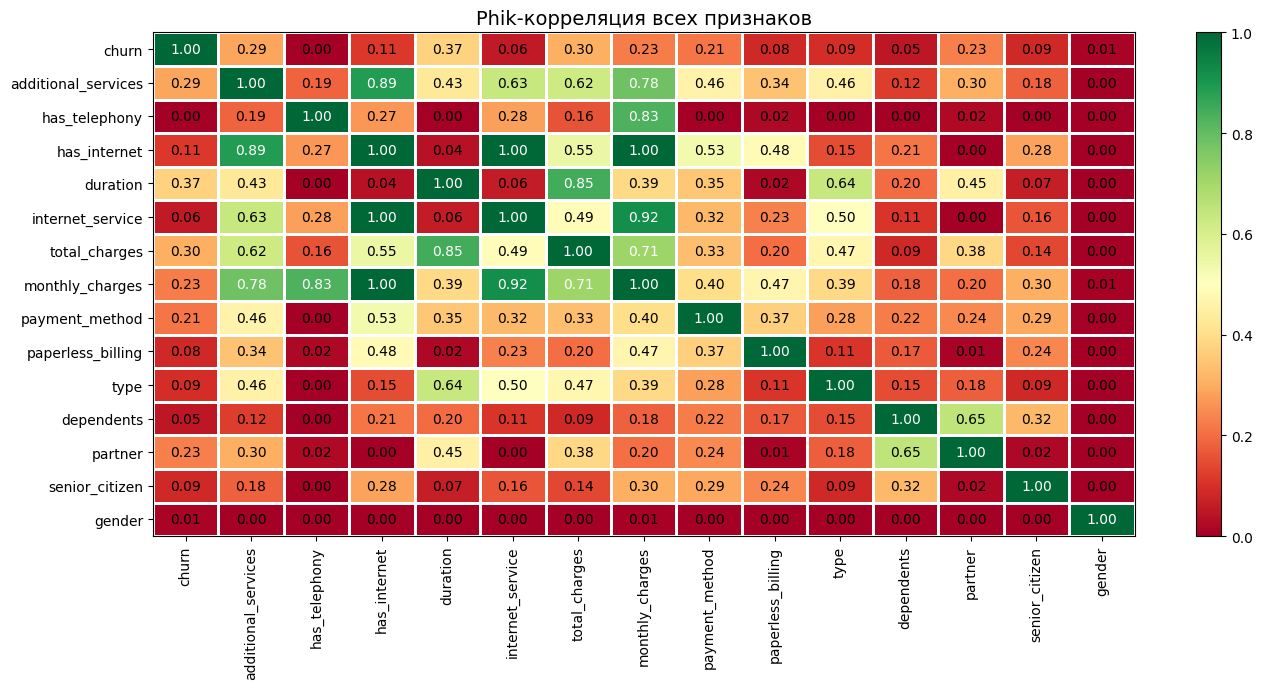

In [91]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, title='Phik-корреляция всех признаков', figsize=(14, 7))
plt.tight_layout()

Сразу бросается в глаза очень высокая корреляция созданного нами признака `has_internet` сразу с несколькими другими признаками и отсутствие какой-либо взаимосвязи признака пола клиента с остальными.  
Оба этих признака могут только повредить обучению модели предсказания ухода клиента, поэтому сразу удалим их:

In [92]:
df = df.drop(['has_internet','gender'], axis=1)

Проверим, какие из признаков **сильнее всего взаимосвязаны с целевым** признаком:

In [93]:
phik_matrix['churn'].sort_values(ascending=False).round(2).head(6)

churn                  1.00
duration               0.37
total_charges          0.30
additional_services    0.29
partner                0.23
monthly_charges        0.23
Name: churn, dtype: float64

**Наибольшая взаимосвязь наблюдается от сгенерированных** нами признаков: продолжительности договора, дополнительных услуг, а также от денежных трат.  
Изучим их подробнее в разрезе факта разрыва договора между клиентом и провайдером.

#### Продолжительность контракта

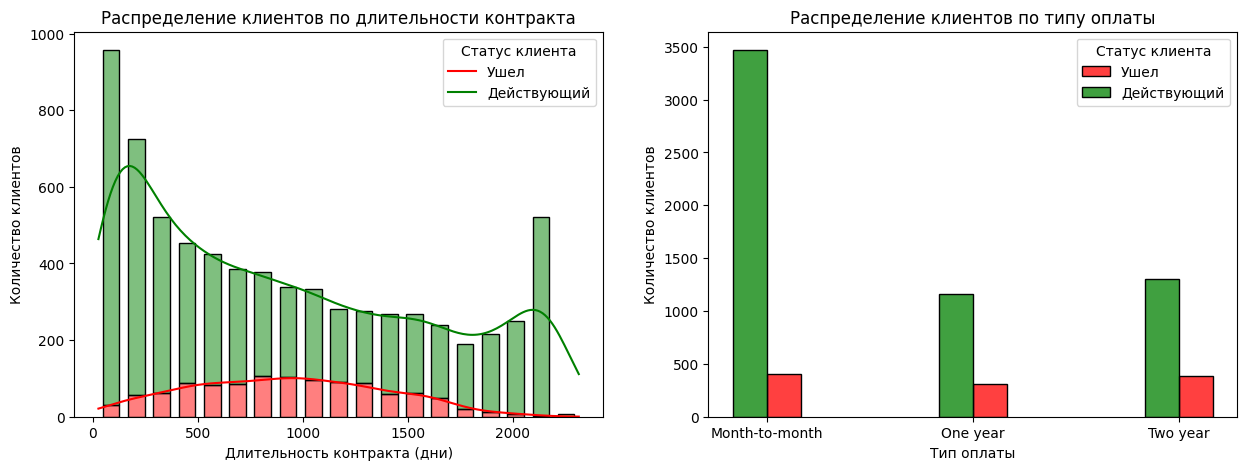

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.histplot(x='type', hue='churn', data=df, palette=['green','red'], multiple='dodge', shrink=0.33, ax=axs[1])
ax1.set_title('Распределение клиентов по типу оплаты')
ax1.set_xlabel('Тип оплаты')
ax1.set_ylabel('Количество клиентов')
ax1.legend(title='Статус клиента', labels=['Ушел', 'Действующий']);

ax2 = sns.histplot(x='duration', hue='churn', data=df, palette=['green','red'], multiple='stack',shrink=0.66,kde=True,ax=axs[0])
ax2.set_title('Распределение клиентов по длительности контракта')
ax2.set_xlabel('Длительность контракта (дни)')
ax2.set_ylabel('Количество клиентов')
ax2.legend(title='Статус клиента', labels=['Ушел', 'Действующий']);

Общее количество клиентов уменьшается с увеличением срока.  
При этом с момента подключения количество "уходов" плавно растет, но **после определенного момента начинает снижаться**.  
Грубо говоря, если клиент не разорвал договор в первые два года, то вероятность его ухода дальше только снижается.  

Интересно, что несмотря на это, есть большое количество действующих клиентов с наибольшим сроком пользования услугами. Возможно, что это те клиенты, которые подключены с самого основания компании или в какой-то промо-период, когда было большое количество подключений и когда начала собираться текущая статистика.  

Также видим, что в абсолютных величинах бОльшая часть клиентов на помесячной абонентской плате.  
Хотя количество ушедших клиентов на помесячной оплате примерно равно количеству ушедших на годовых планах, в процентном соотношении **доля ушедших с годовых планов намного больше**.  
Подтвердим это численно:

In [95]:
df.groupby('type')['churn'].agg(['mean','count'])

,mean,count
type,,
Month-to-month,0.105032,3875
One year,0.212636,1472
Two year,0.226113,1685


Возможно, клиенты, сидят на годовых планах на протяжении всего срока контракта, а по его окончанию сразу разрывают договор из-за ставших невыгодными за прошедшие год-два условий.  
Попробуем разбить продолжительность контракта на категории и проверить это предположение.

In [96]:
df['duration_category'] = pd.qcut(df['duration'], q=10)
df.groupby('duration_category',dropna=False)['churn'].agg(['mean','count'])

,mean,count
duration_category,,
"(27.999, 92.0]",0.037657,717
"(92.0, 215.0]",0.060123,815
"(215.0, 365.0]",0.103448,667
"(365.0, 549.0]",0.179148,681
"(549.0, 761.0]",0.231928,664
"(761.0, 1006.0]",0.304167,720
"(1006.0, 1279.0]",0.300146,683
"(1279.0, 1614.0]",0.249311,726
"(1614.0, 2010.0]",0.098266,692


Разбили на примерно равные по количеству клиентов группы, теперь оценим визуально долю ушедших клиентов в каждой группе:

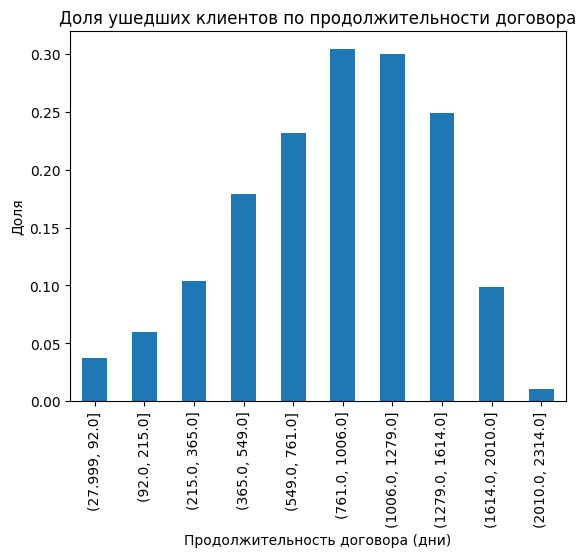

In [97]:
df.groupby('duration_category',dropna=False)['churn']\
    .agg('mean')\
    .plot(kind='bar', title='Доля ушедших клиентов по продолжительности договора');
plt.xlabel('Продолжительность договора (дни)')
plt.ylabel('Доля')
plt.show();

Эта диаграмма подтверждает ранее замеченное наблюдение о том, что **с момента подключения первые два года вероятность разрыва контракта постоянно растет, а после этого срока вероятность ухода клиента начинает снижаться**.  

Попробуем найти взаимосвязь между продолжительностью контракта и уходом клиента _в разрезе типа контракта_:

In [98]:
t = df.pivot_table(index='duration_category', values='churn', columns='type', aggfunc='mean')
t.columns = [''.join(col).strip() for col in t.columns.values]
t.reset_index()

,duration_category,Month-to-month,One year,Two year
0,"(27.999, 92.0]",0.030612,0.136364,0.333333
1,"(92.0, 215.0]",0.044000,0.219512,0.291667
2,"(215.0, 365.0]",0.063910,0.207317,0.339623
3,"(365.0, 549.0]",0.118852,0.268293,0.442857
4,"(549.0, 761.0]",0.171149,0.288344,0.402174
5,"(761.0, 1006.0]",0.202100,0.310185,0.609756
6,"(1006.0, 1279.0]",0.242321,0.280000,0.430303
7,"(1279.0, 1614.0]",0.172775,0.207273,0.350000
8,"(1614.0, 2010.0]",0.078125,0.068182,0.125000
9,"(2010.0, 2314.0]",0.000000,0.019048,0.009174


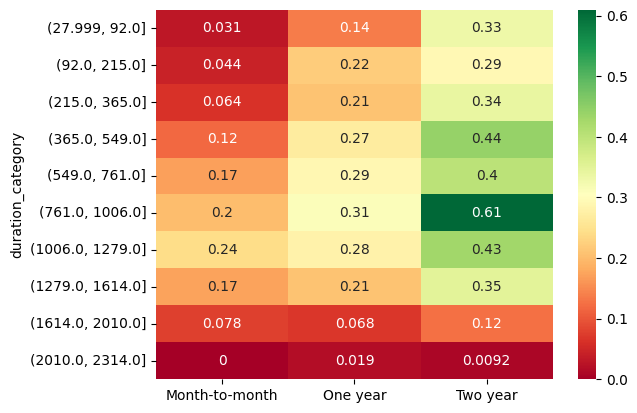

In [99]:
sns.heatmap(t, annot=True, cmap='RdYlGn');

По диаграмме выше наглядно видно, что доля ушедших с помесячных контрактов клиентов не так высока и не так сильно растёт с увеличением продолжительности срока по сравнению с одно- и особенно двухлетними контрактами.  
И как раз в период от 2 - 2.5 лет вероятность ухода клиента на двухлетнем контракте максимальна.  
**Доля ушедших в период 760-1000 дней после заключения договора больше, чем доля оставшихся**.  

Это подтверждает предположение о том, что **чаще всего уход клиента связан с тем, что он заключает двухлетний контракт и по прошествии этих двух лет решает разорвать договор**.  

#### Размер оплаты 
Если клиенты уходят чаще с долгосрочных контрактов, то возможно, их условия у провайдера не такие выгодные, как у контрактов с помесячной оплатой?  
Проверим средний месячный чек у разных типов контрактов:

In [100]:
df.groupby('type')['monthly_charges'].agg(['mean','count'])

,mean,count
type,,
Month-to-month,66.398490,3875
One year,65.079416,1472
Two year,60.872374,1685


Нет, это предположение не подтвердилось. Долгосрочные контракты в пересчете на средний месячный чек выходят дешевле, чем краткосрочные. Это логично, значит явных проблем с тарифами у оператора нет.  

Но оба "денежных" признака, и `monthly_charges` и `total_charges` были в топе списка коррелирующих с оттоком клиентов.  
Сначала оценим визуально распределение клиентов по ежемесячным и суммарным тратам _в разрезе оттока_ клиентов:

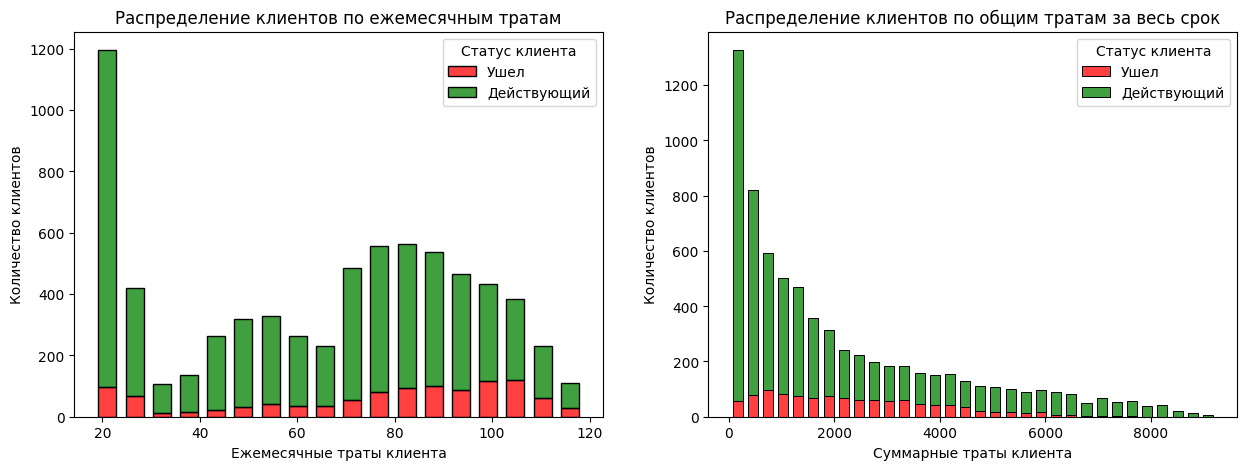

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.histplot(x='monthly_charges',hue='churn',data=df, palette=['green','red'], multiple='stack', shrink=0.66, ax=axs[0])
ax1.set_title('Распределение клиентов по ежемесячным тратам')
ax1.set_xlabel('Ежемесячные траты клиента')
ax1.set_ylabel('Количество клиентов')
ax1.legend(title='Статус клиента', labels=['Ушел', 'Действующий']);

ax2 = sns.histplot(x='total_charges',hue='churn',data=df, palette=['green','red'], multiple='stack', shrink=0.66, ax=axs[1])
ax2.set_title('Распределение клиентов по общим тратам за весь срок')
ax2.set_xlabel('Суммарные траты клиента')
ax2.set_ylabel('Количество клиентов')
ax2.legend(title='Статус клиента', labels=['Ушел', 'Действующий']);

plt.show()

Видим, что большое количество клиентов используют самые дешевые тарифы с точки зрения ежемесячной оплаты, но однозначную взаимосвязь с оттоком трудно разглядеть.  

На втором графике видно, что общее количество клиентов падает с ростом их суммарных трат. Это логично - большие суммарные траты линейно связаны с продолжительностью пользования услугами. А новых клиентов, как мы выяснили ранее, больше чем "старых".  

Вообще, с учетом того, что у столбца с общими тратами `total_charges` есть сильная корреляция как с продолжительностью пользования `duration`, так и с рассмотренной тут же ежемесячной платой `monthly_charges`, его стоит удалить из датафрейма перед разбиением на выборки.

Попробуем разбить всех клиентов на более крупные категории, чтобы более наглядно _проверить взаимосвязь ежемесячных плат и ухода клиента_.

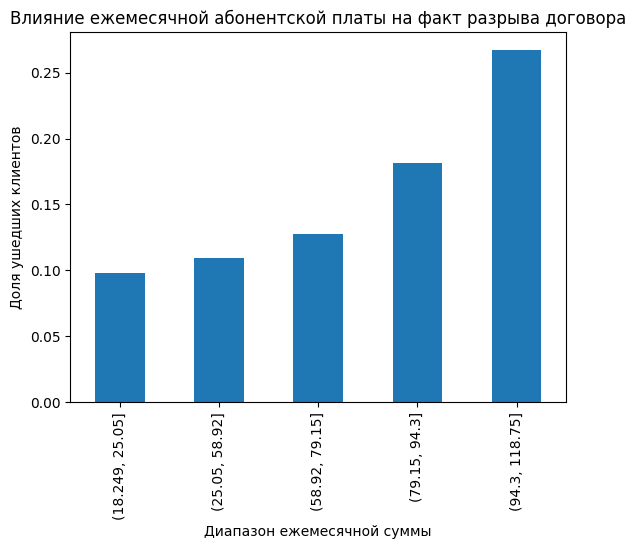

In [102]:
df['monthly_charges_category'] = pd.qcut(df['monthly_charges'], q=5)
t = df.groupby('monthly_charges_category',dropna=False)['churn'].agg('mean')
ax = t.plot(kind='bar', title='Влияние ежемесячной абонентской платы на факт разрыва договора');
ax.set_xlabel("Диапазон ежемесячной суммы");
ax.set_ylabel("Доля ушедших клиентов");

Видим, что при разбиении на диапазоны становится заметной линейная **зависимость вероятности "ухода" от ежемесячной платы**.  

#### Доп. услуги и тип подключения

Проверим распределение клиентов в таком же разрезе (действующий\ушедший клиент) по другим признакам: количеству подключенных дополнительных услуг и типу подключения:

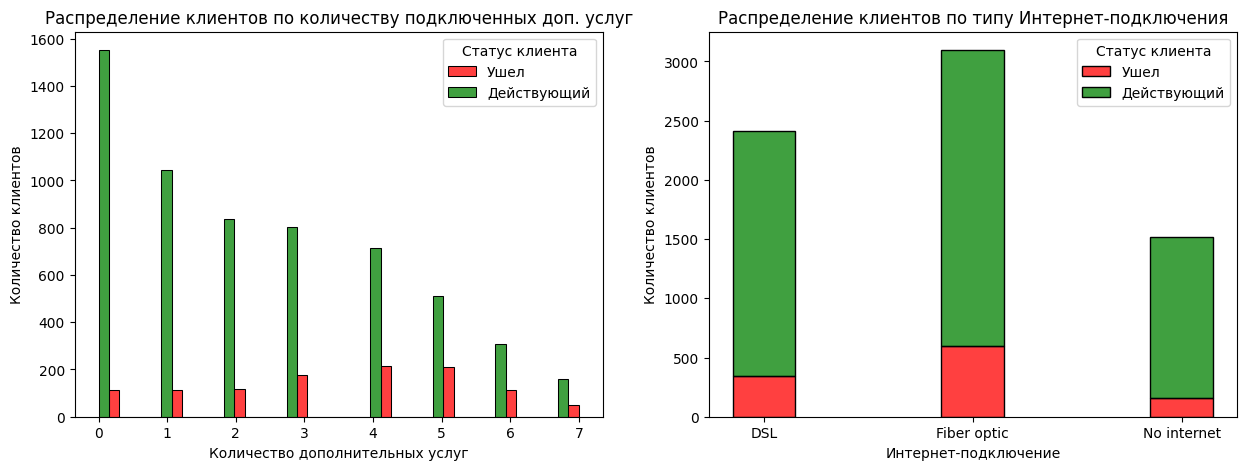

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.histplot(x='additional_services',hue='churn',data=df, palette=['green','red'], multiple='dodge', ax=axs[0])
ax1.set_title('Распределение клиентов по количеству подключенных доп. услуг')
ax1.set_xlabel('Количество дополнительных услуг')
ax1.set_ylabel('Количество клиентов')
ax1.legend(title='Статус клиента', labels=['Ушел', 'Действующий']);

ax2 = sns.histplot(x='internet_service',hue='churn',data=df, palette=['green','red'], multiple='stack', shrink=0.3, ax=axs[1])
ax2.set_title('Распределение клиентов по типу Интернет-подключения')
ax2.set_xlabel('Интернет-подключение')
ax2.set_ylabel('Количество клиентов')
ax2.legend(title='Статус клиента', labels=['Ушел', 'Действующий']);

plt.show()

Касательно типа подключения - тут не наблюдается какой-либо однозначной зависимости. Большая часть клиентов подключена через оптику.  
Вопреки ожиданиям, доля ушедших среди DSL-клиентов не так высока и сравнима с теми, кто использует оптоволокно. Значит, пользователей устраивает скорость\качество Интернета через телефонную линию.

Визуально заметно, что **большинство клиентов не пользуются дополнительными услугами**, а **при увеличении количества услуг растет и доля ушедших**.  Но среди клиентов с максимальным количеством подключенных (6-7) услуг эта доля похоже падает. Попробуем убедиться в этом:

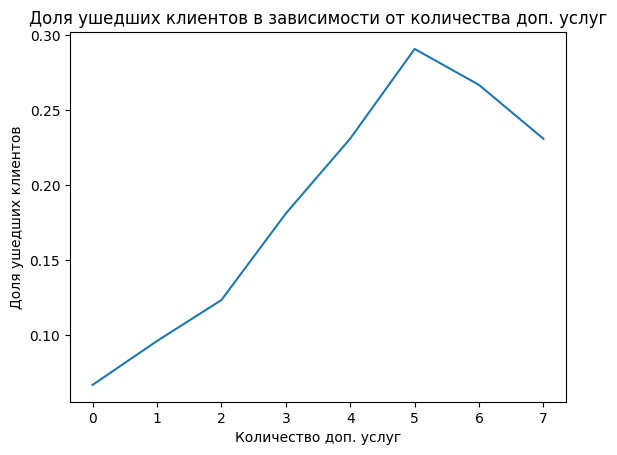

In [104]:
ax = df.groupby('additional_services')['churn'].agg(['mean'])\
    .plot(title='Доля ушедших клиентов в зависимости от количества доп. услуг', legend=None);
ax.set_xlabel("Количество доп. услуг");
ax.set_ylabel("Доля ушедших клиентов");

Действительно, клиентов с максимальным количеством подключенных услуг очень мало, и доля ушедших там немного ниже максимума.  
Но этот процент ушедших всё еще на значительном уровне (больше 20%). И это выше, чем у тех, кто подключил поменьше доп. услуг (0-4).  

Можно сделать вывод, что **большое количество дополнительных услуг отрицательно влияет на перспективы клиента остаться**.


#### Социальное положение

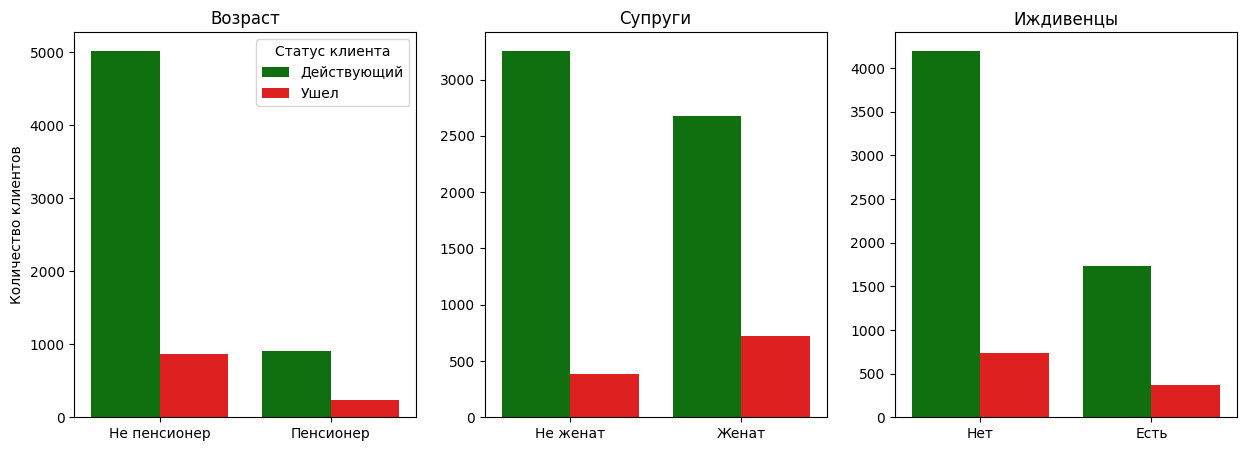

In [105]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ax1 = sns.countplot(x='senior_citizen',hue='churn',data=df, palette=['green','red'], ax=axs[0])
ax1.set_title('Возраст')
ax1.set_xlabel('')
ax1.set_ylabel('Количество клиентов')
ax1.set_xticklabels(['Не пенсионер', 'Пенсионер'])
ax1.legend(title='Статус клиента', labels=['Действующий', 'Ушел'])

ax2 = sns.countplot(x='partner',hue='churn',data=df, palette=['green','red'],  ax=axs[1])
ax2.set_title('Супруги')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xticklabels(['Не женат', 'Женат'])
ax2.get_legend().remove()

ax3 = sns.countplot(x='dependents',hue='churn',data=df, palette=['green','red'],  ax=axs[2])
ax3.set_title('Иждивенцы')
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_xticklabels(['Нет', 'Есть'])
ax3.get_legend().remove()

plt.show();

Как уже заметили раньше, **бОльшая часть клиентов без какой-либо социальной нагрузки**.  

Визуально заметно, что **отток выше среди женатых** клиентов.

### Выводы
 - Были удалены признаки `gender` (ни на что не влияет) и `has_internet` (сильно коррелирует с другими).  
 Также будет удален признак `total_charges` - аналогично `has_internet` он по сути дублирует другие признаки.
 - С точки зрения среднего чека более выгодны долгосрочные контракты, а высокая ежемесячная плата увеличивает шанс отказаться от услуг.  
 Но клиенты на тарифах с помесячной оплатой реже уходят от провайдера, не смотря на то, что платят немного больше.  
 А клиенты с долгосрочными контрактами начинают активно уходить от провайдера после завершения срока контракта (особенно через 2 года).
 - Если же получилось удержать клиента дольше 3 лет, то он с большей вероятностью останется у провайдера. 
 - Дополнительные услуги и наличие супруга отрицательно влияют на лояльность клиента

## Моделирование

Перед построением моделей необходимо понять, какой баланс категорий в целевом классе:

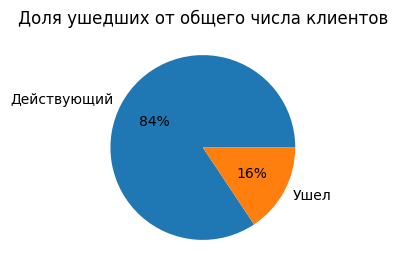

In [106]:
df['churn'].value_counts().plot(kind='pie', title='Доля ушедших от общего числа клиентов', autopct='%1.f%%',
                                figsize=(3,3), labels=['Действующий','Ушел'], legend=None, ylabel='');
print()

Исправлять дисбаланс не будем, так как он отражает реальность - активных клиентов у провайдера скорее всего все-таки больше, чем ушедших.  
Но при разбиении на выборки стратифицируем их по целевому признаку.  
А при обучении логистической регрессии добавим веса соответственно балансу классов с помощью `class_weight='balanced'`.

То есть, нам предстоит **решать задачу классификации с дисбалансом целевого класса** в соотношении примерно 5:1.

Удалим признаки, которые были созданы при анализе и которые не понадобятся при обучении модели.

In [107]:
df = df.drop(['customer_id','total_charges','duration_category','monthly_charges_category'], axis=1)

**Итого**, перед обучением набор данных выглядит так:

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   senior_citizen       7032 non-null   bool   
 1   partner              7032 non-null   bool   
 2   dependents           7032 non-null   bool   
 3   type                 7032 non-null   object 
 4   paperless_billing    7032 non-null   bool   
 5   payment_method       7032 non-null   object 
 6   monthly_charges      7032 non-null   float64
 7   internet_service     7032 non-null   object 
 8   duration             7032 non-null   int64  
 9   has_telephony        7032 non-null   bool   
 10  additional_services  7032 non-null   int32  
 11  churn                7032 non-null   int32  
dtypes: bool(5), float64(1), int32(2), int64(1), object(3)
memory usage: 418.9+ KB


In [109]:
df.head(5)

,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,internet_service,duration,has_telephony,additional_services,churn
0,False,True,False,Month-to-month,True,Electronic check,29.85,DSL,31,False,1,0
1,False,False,False,One year,False,Mailed check,56.95,DSL,1036,True,2,0
2,False,False,False,Month-to-month,True,Mailed check,53.85,DSL,123,True,2,0
3,False,False,False,One year,False,Bank transfer (automatic),42.30,DSL,1371,False,3,0
4,False,False,False,Month-to-month,True,Electronic check,70.70,Fiber optic,153,True,0,0


### Подготовка выборок

Выделим из датафрейма обучающую и тестовую выборки в соотношении 3:1:

In [110]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)

Убедимся, что доля классов целевого признака в выборках примерно одинакова:

In [111]:
print(y.mean().round(2))
print(y_train.mean().round(2))
print(y_test.mean().round(2))

0.16
0.16
0.16


Выделим категориальные и числовые столбцы:  

_Количество дополнительных услуг `additional_services` оставляем как численный признак, поскольку расстояние между различными значениями имеет смысл и их можно численно сравнивать ("больше-меньше")._

In [112]:
cols_num = X_train.select_dtypes(include=['float64','int64', 'int32']).columns.to_list()
print('Численные:', cols_num)
cols_cat = X_train.select_dtypes(include=['object']).columns.to_list()
print('Категориальные', cols_cat)
cols_cat_with_bool = X_train.select_dtypes(include=['object','bool']).columns.to_list()
print('Категориальные (включая булевы):', cols_cat_with_bool)

Численные: ['monthly_charges', 'duration', 'additional_services']
Категориальные ['type', 'payment_method', 'internet_service']
Категориальные (включая булевы): ['senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing', 'payment_method', 'internet_service', 'has_telephony']


### Подготовка кодирования и масштабирования

Подготовим пайплайны для каждого набора столбцов: категориальные будут кодироваться через OHE, а числовые - масштабироваться.  
Так как количество категорий в каждом признаке невелико, то OHE подойдет для бустинговой модели (к тому же используем `drop='first'`).  

Закодированные столбцы и столбцы булевого типа дополнительно масштабировать не будем.  

А в CatBoost передадим признаки без кодирования и масштабирования, просто укажем список категориальных признаков (включая булевы).

In [113]:
num_scaler = Pipeline(steps=[("scaler", StandardScaler())])
cat_ohe = Pipeline(steps=[("ohe", OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))])

Создадим общий трансформер, включающий оба пайплайна:

In [114]:
col_transformer = ColumnTransformer(
    transformers=[
        ("num", num_scaler, cols_num),
        ("cat", cat_ohe, cols_cat)
    ], remainder='passthrough' # столбцы булевого типа передаются как есть
)

Теперь обучим модели, с подбором гиперпараметров через GridSearch (небольшая сетка) на 3 фолдах.  
В качестве метрики используем ROC-AUC.

### LogisticRegression

In [115]:
param_grid = {
    "model__C": [0.1, 1.0, 100],
    "model__max_iter": [100, 500],
}
pipe = Pipeline(steps=[("col_transformer", col_transformer), 
                       ("model", LogisticRegression(random_state=SEED, class_weight='balanced'))])

search_cv = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=3, verbose=1)

In [116]:
search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('col_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'duration',
                                                                          'additional_services']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['type',
                                                                          'payment_method',
                                                                          'internet_service'])])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=190623))]),
             param_grid={'model__C': [0.1, 1.0, 100],
                         'model__max_iter': [100, 500]},
             scoring='roc_auc', verbose=1)

In [117]:
print('Лучшие гиперпараметры:', search_cv.best_params_)
print(f'Метрика на кросс-валидации: {search_cv.best_score_:.3f}')
results = pd.DataFrame({'ROC-AUC':search_cv.best_score_.round(3)}, index=['LogisticRegression'])

Лучшие гиперпараметры: {'model__C': 1.0, 'model__max_iter': 100}
Метрика на кросс-валидации: 0.748


### GradientBoostingClassifier

In [118]:
param_grid = {
    "model__learning_rate": [0.1, 1],
    "model__n_estimators": [50, 100],
    "model__max_features": [5, 8],
}
pipe = Pipeline(steps=[("col_transformer", col_transformer), ("model", GradientBoostingClassifier(random_state=SEED))])

search_cv = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=3, verbose=1)
search_cv

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('col_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'duration',
                                                                          'additional_services']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['type',
                                                                          'payment_method',
                                                                          'internet_service'])])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=190623))]),
             param_grid={'model__learning_rate': [0.1, 1],
                         'model__max_features': [5, 8],
                         'model__n_estimators': [50, 100]},
             scoring='roc_auc', verbose=1)

In [119]:
search_cv.fit(X_train, y_train)
print('Лучшие гиперпараметры:', search_cv.best_params_)
print(f'Метрика на кросс-валидации: {search_cv.best_score_:.3f}')
results = pd.concat([results,pd.DataFrame({'ROC-AUC':search_cv.best_score_.round(3)}, index=['GradientBoostingClassifier'])])

Fitting 3 folds for each of 8 candidates, totalling 24 fits


Лучшие гиперпараметры: {'model__learning_rate': 1, 'model__max_features': 8, 'model__n_estimators': 50}
Метрика на кросс-валидации: 0.859


### CatBoostClassifier

In [120]:
param_grid = {
    "learning_rate": [0.01, 0.5],
    "iterations": [100, 500]
}
model = CatBoostClassifier(random_state=SEED, cat_features=cols_cat_with_bool, 
                           logging_level='Silent')

search_cv = GridSearchCV(model, param_grid, scoring='roc_auc', cv=3, verbose=1,error_score='raise')
search_cv

GridSearchCV(cv=3, error_score='raise',
             estimator=<catboost.core.CatBoostClassifier object at 0x000001B6D257EE20>,
             param_grid={'iterations': [100, 500],
                         'learning_rate': [0.01, 0.5]},
             scoring='roc_auc', verbose=1)

In [121]:
search_cv.fit(X_train, y_train)
print('Лучшие гиперпараметры:', search_cv.best_params_)
print(f'Метрика на кросс-валидации: {search_cv.best_score_:.3f}')
results = pd.concat([results,pd.DataFrame({'ROC-AUC':search_cv.best_score_.round(3)}, index=['CatBoostClassifier'])])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


Лучшие гиперпараметры: {'iterations': 500, 'learning_rate': 0.5}
Метрика на кросс-валидации: 0.888


### Выбор лучшей модели и результаты

In [122]:
display(results)

,ROC-AUC
LogisticRegression,0.748
GradientBoostingClassifier,0.859
CatBoostClassifier,0.888


Наилучшую метрику ROC-AUC на кросс-валидации показала **модель CatBoost**.  

Она прошла проверку на адекватность (ROC-AUC > 0.5)

Модель уже сохранена в GridSearch, поэтому сразу применим её и вычислим метрики на тестовой выборке:

#### ROC-AUC

In [123]:
y_score = search_cv.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_score)
print('ROC-AUC:', auc_roc.round(3))

ROC-AUC: 0.927


Построим график ROC-кривой, добавим так же график константной модели.

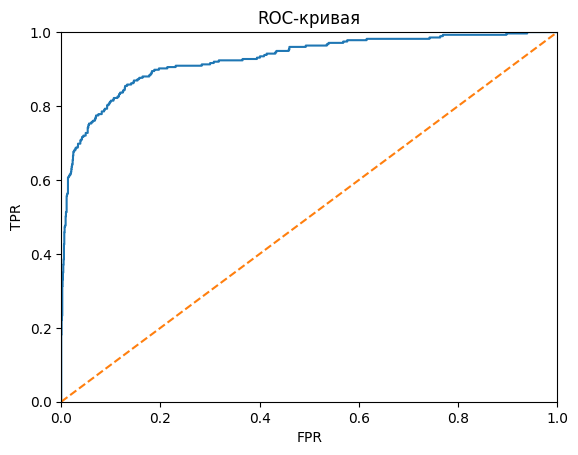

In [124]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr)
plt.xlim([0, 1]); plt.ylim([0, 1])
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show();

#### Confusion Matrix

Получаем сами предсказания:

In [125]:
y_pred = search_cv.best_estimator_.predict(X_test)

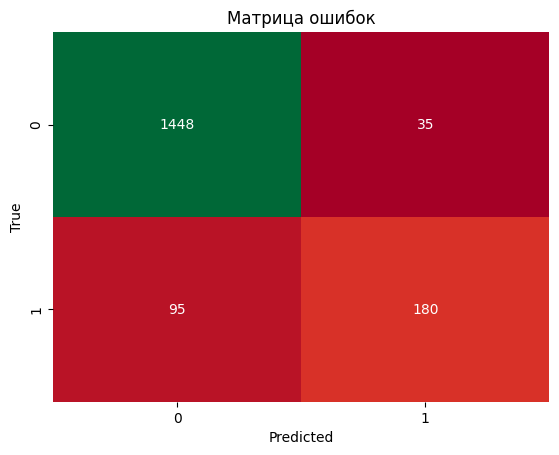

In [126]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='RdYlGn', fmt='g', cbar=False)
plt.title('Матрица ошибок')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Accuracy

Для вычисления Accuracy можно просто взять отношение суммы всех правильных предсказаний к их общему количеству:

In [127]:
print('Accuracy:', round((1448 + 180) / len(y_test),3))

# или через sklearn
print('Accuracy:', accuracy_score(y_test, y_pred).round(3))

Accuracy: 0.926
Accuracy: 0.926


#### Feature importance

Выясним, как модель оценивала важность признаков при обучении. Для этого получим массив feature_importances из GridSearch и сопоставим его с названиями столбцов датафрейма.

In [128]:
search_cv.best_estimator_.feature_importances_

array([ 2.08926909,  3.79191606,  3.07486473,  8.02088736,  2.08874394,
        7.94923164, 16.46430172,  3.37140316, 46.1417307 ,  0.76055928,
        6.24709231])

In [129]:
fi = (pd.DataFrame({'importance': search_cv.best_estimator_.feature_importances_}, index=[X.columns])
    .sort_values('importance', ascending=False))

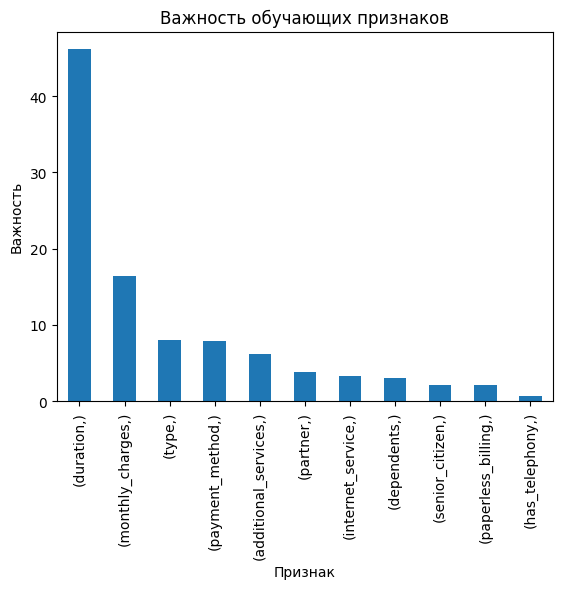

In [130]:
ax = fi.plot(y='importance', kind='bar', legend=None);
ax.set_title('Важность обучающих признаков')
ax.set_xlabel('Признак')
ax.set_ylabel('Важность');

Видим, что признак продолжительности контракта очень сильно повлиял на прогнозы модели, несмотря на то, что phik-корреляция этого признака с целевым была слабой.  
Признаки типа оплаты и ежемесячных трат также внесли весомый вклад в прогнозы.  
А вот признаки, характеризующие социальное положение, тип подключения и вид доставки платежа, не оказывали существенного влияния.

### Выводы

Проверили три модели: два бустинга и одну линейную.  
Модель CatBoost показала наилучшую метрику ROC-AUC на кросс-валидации. Немного странно, что на тестовой выборке ROC-AUC стала еще лучше, а метрика accuracy практически равна ROC-AUC.  
Среди признаков наиболее важным оказался признак продолжительности контракта клиента, который был получен из дат заключения и разрыва договора.

# Отчет по решению
Этот отчет содержит информацию по исследованию и предсказанию оттока клиентов оператора связи "Ниединогоразрыва.com".

## Исходные данные
Оператор предоставляет следующие услуги:
 - Телефон (одна или несколько линий)
 - Интернет (DSL или оптоволоконное подключение)  
 
а также дополнительные Интернет- и телефонные услуги.  
Для клиентов доступны различные типы оплаты: помесячная, оплата за 1 год, оплата за 2 года с различными способами расчета и получения чеков.
 
Оператор предоставил деперсонифицированные данные о клиентах в 4 выгрузках, объединенных идентификатором клиента и содержащих информацию о клиенте, заключенном договоре и подключенных дополнительных услугах на 01.02.2020. 

## Выполненные работы
В соответствии с предварительным планом работ были проведены предобработка, анализ данных и выбор подходящей модели машинного обучения для предсказания возможного ухода клиента. Были выполнены все пункты плана:


### Предобработка данных
Данные всех выгрузок были объединены по идентификатору клиента.  
Явных дубликатов и пропусков при этом не найдено, но оказалось, что в выгрузке отсутствует информация по общим расходам клиента, если клиент заключает договор в день формирования выгрузки.  

Столбцы выгрузки на основании заполненных значений были приведены к более подходящим типам данных.  
На основании имеющихся столбцов были сформированы новые признаки, включая целевой признак - факт оттока клиента.  

Часть столбцов была исключена из исследования - из-за сильной или наоборот, слишком слабой корреляции с другими признаками.

Итоговый список признаков, который использовался для обучения моделей:
 - индекс строки (автоматический)
 - пенсионер по возрасту (`senior_citizen`)
 - наличие супруга (`partner`)
 - наличие иждивенцев (`dependents`)
 - тип контракта (`type`)
 - продолжительность контракта (`duration`)
 - тип биллинга (`paperless_billing`)
 - способ оплаты (`payment_method`)
 - тип интернет-подключения (`internet_service`)
 - наличие телефонного подключения (`has_telephony`)
 - количество дополнительных услуг (`additional_services`)
 - ежемесячные платежи (`monthly_charges`)
 - факт ухода клиента (`churn`)

 
### Анализ данных

При анализе данных были выявлены следующие зависимости, на которые заказчику следует обратить внимание:
1. Социальное положение клиента само по себе слабо влияет на факт оттока, хотя среди холостых отток всё же меньше.  
Но социальное положение может учитываться при заключении контракта и предложении дополнительных услуг (см. далее).  
Из положительных моментов стоит отметить, что качество DSL-подключения скорее всего, не влияет на факт ухода.
2. Чаще всего расторгают договор клиенты с большим количеством подключенных дополнительных услуг и большой ежемесячной оплатой.<br>
<img src='https://drive.google.com/uc?export=view&id=1IaJopGk83MEpHsb1eEzXT-fj1zNAOt5E'>
3. Отдельно стоит обратить внимание на клиентов с долгосрочными договорами, чьи сроки подходят к концу:  
определено, что клиенты на двухлетних контрактах часто расторгают договоры в течение 2-3 лет после их заключения.<br>
<img src='https://drive.google.com/uc?export=view&id=1pQHFFnDs0CvJ14Tx4IJExT6uZ4ZJ5ReO'>


### Построение моделей
При построении моделей решалась задача бинарной классификации - определение факта ухода клиента.  
Исходные данные были разделены на две выборки в соотношении **75% / 25%**.  

В выборках было сохранено соотношение категорий целевого признака: 84% (действующие клиенты) / 16% (ушедшие клиенты). Дополнительной работы по исправлению дисбаланса не проводилось.  

В проекте были протестированы три модели: _LogisticRegression_ и _GradientBoostingClassifier_ из библиотеки sklearn, а также _CatBoostClassifier_.

Перед обучением моделей категориальные признаки были закодированы с помощью _One-Hot Encoder_.  
Список признаков:
 - пенсионер по возрасту (`senior_citizen`)
 - наличие супруга (`partner`)
 - наличие иждивенцев (`dependents`)
 - тип контракта (`type`)
 - тип биллинга (`paperless_billing`)
 - способ оплаты (`payment_method`)
 - тип интернет-подключения (`internet_service`)
 - наличие телефонного подключения (`has_telephony`)
 
Численные признаки были приведены к одному масштабу с помощью _StandardScaler_.  
Список признаков:
 - продолжительность контракта (`duration`)
 - количество дополнительных услуг (`additional_services`)
 - ежемесячные платежи (`monthly_charges`)
 
Для модели CatBoost использовался встроенный кодировщик, поэтому предварительного преобразования признаков не проводилось.

По итогам кросс-валидации с метрикой ROC-AUC была выбрана лучшая модель - _CatBoostClassifier_ со следующими параметрами:
- `learning_rate = 0.5`
- `iterations = 500`
- `random_state = 190623`
- `depth = 6` (по умолчанию)
- `l2_leaf_reg = 3` (по умолчанию)

Модель показала метрику ROC-AUC: **0.927** на тестовой выборке.  

Точность предсказаний (accuracy) на тестовой выборке (1758 объектов) составила **92,6%**, а именно:

|  **Ответы модели** | **Доля от общего количества** |                 **Описание**                 |
|:------------------:|:-----------------------------:|:--------------------------------------------:|
| **True Positive**  | 10%                           | <span style="color:green">Верное предсказание</span>, что клиент уйдет        |
| **True Negative**  | 83%                           | <span style="color:green">Верное предсказание</span>, что клиент останется    |
| **False Positive** | 2%                            | Ложное срабатывание, что клиент уйдет        |
| **False Negative** | 5%                            | Ошибочное предсказание, что клиент останется |

Наиболее важные признаки, повлиявшие на предсказания модели: 
1. продолжительность контракта (`duration`)
2. ежемесячные платежи (`monthly_charges`)
3. тип контракта (`type`)
4. способ оплаты (`payment_method`)
5. количество дополнительных услуг (`additional_services`)

## Итоги проекта
Наиболее подвержены оттоку клиенты на долгосрочных контрактах после их завершения (через 2-3 года).  
Стоит внести изменения в политику работы с такими клиентами. На снижение оттока положительно скажется уменьшение количества подключаемых клиенту дополнительных услуг и снижение его ежемесячных платежей.  
Для предсказания оттока клиента рекомендуется использовать модель машинного обучения CatBoost, которая cможет предсказать уход клиента с точностью ~93%. 